Load the data.

In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dmml_project import PROJECT_ROOT
from dmml_project.models.hyperparameters import HYPERPARAMETERS

beautiful_names = {
    "decision_tree": "Decision Tree",
    "random_forest": "Random Forest",
    "neural_network": "Neural Network",
}
def load_results(n: int):
    search_results = {}
    for model_kind in beautiful_names.keys():
        postfix = "" if n == 0 else f"_{n}"
        path = f"{PROJECT_ROOT}/data/{model_kind}_search{postfix}.json"
        try:
            with open(path, 'r') as f:
                data = json.load(f)
                search_results[model_kind] = data["search_results"]
        except FileNotFoundError:
            print(f"Skipping {model_kind} as no search results were found")
    return search_results

search_results = [load_results(0), load_results(1)]

Skipping random_forest as no search results were found
Skipping neural_network as no search results were found


Create a dataframe for the violin plot.

In [2]:

violin_plot_data = pd.DataFrame(columns=["accuracy_mean", "accuracy_std", "model_kind", "iteration"])
for i in range(len(search_results)):
    for model_kind, results in search_results[i].items():
        for result in results:
            accuracies = np.array(result[1])
            mean = np.mean(accuracies)
            std = np.std(accuracies)
            violin_plot_data.loc[len(violin_plot_data)] = [mean, std, beautiful_names[model_kind], i]

Display the plot.

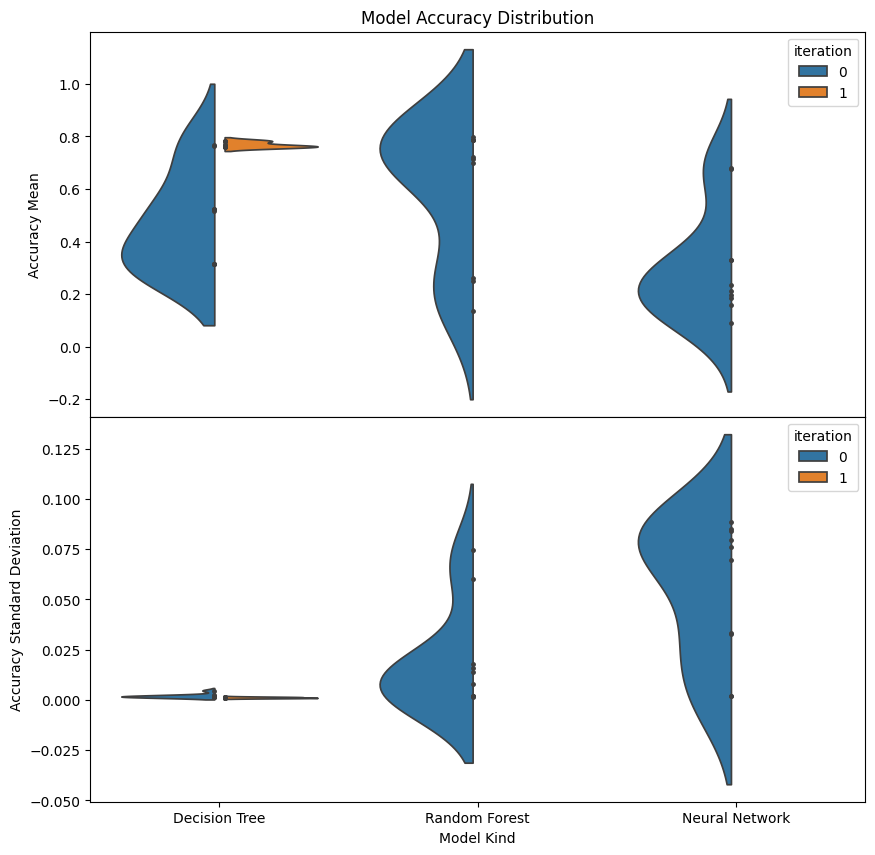

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10, 10))
axs[0].set_title("Model Accuracy Distribution")
violin_plot_args = {
    "data": violin_plot_data, 
    "x": "model_kind", 
    "hue": "iteration", 
    "split": True, 
    "gap": 0.1, 
    "density_norm": "width", 
    "inner": "points", 
}
sns.violinplot(y="accuracy_mean", ax=axs[0], **violin_plot_args,)
axs[0].set_ylabel("Accuracy Mean")
sns.violinplot(y="accuracy_std", ax=axs[1], **violin_plot_args,)
axs[1].set_xlabel("Model Kind")
axs[1].set_ylabel("Accuracy Standard Deviation")
plt.show()

Calculate the best model for each model type.

In [4]:
best_results = {}
for i in range(len(search_results)):
    for model_kind, results in search_results[i].items():
        if model_kind not in best_results:
            best_results[model_kind] = {
                "accuracy": 0,
                "accuracy_distribution": None,
                "params": None
            }
        for result in results:
            accuracies = np.array(result[1])
            mean = np.mean(accuracies)
            if mean > best_results[model_kind]["accuracy"]:
                best_results[model_kind]["accuracy"] = mean
                best_results[model_kind]["accuracy_distribution"] = accuracies
                best_results[model_kind]["params"] = result[0]
                

Print the best model for each model type.

In [5]:
for model_kind, result in best_results.items():
    print(f"Best {beautiful_names[model_kind]} accuracy: {result['accuracy']*100:.2f}%")
    print(f"Best {beautiful_names[model_kind]} hyperparameters: {result['params']}")

Best Decision Tree accuracy: 78.37%
Best Decision Tree hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_impurity_decrease': 1e-05, 'class_weight': 'balanced'}
Best Random Forest accuracy: 79.71%
Best Random Forest hyperparameters: {'n_estimators': 100, 'criterion': 'log_loss', 'max_depth': None, 'min_impurity_decrease': 1e-06, 'n_jobs': -1, 'class_weight': 'balanced'}
Best Neural Network accuracy: 68.07%
Best Neural Network hyperparameters: {'network': 'ff_binary', 'base_size': 64, 'depth': 2, 'epochs': 10, 'dropout': 0, 'batchnorm': False, 'batch_size': 32, 'lr': 0.1, 'optimizer': 'adam'}
